In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt

In [2]:
from models import CNN

In [21]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np

# Load model and data

In [3]:
cnn = CNN()
cnn.load_state_dict(torch.load('output/cnn-mnist.pkl'))

<All keys matched successfully>

In [4]:
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=False,
)

In [5]:
train_loader = Data.DataLoader(dataset=train_data, batch_size=1024, shuffle=True)

In [6]:
batch_x, batch_y = next(iter(train_loader))

# Capture activations

In [7]:
conv1 = cnn.conv1[1] # after RELU
conv2 = cnn.conv2[1] # after RELU

In [8]:
saved_input = None
saved_activations_conv1 = None
saved_activations_conv2 = None

def store_activations_conv1(module, input_, output):
    global saved_input, saved_activations_conv1
    saved_input, = input_
    saved_input = saved_input.detach().numpy().copy()
    saved_activations_conv1 = output.detach().numpy().copy()
    return None

def store_activations_conv2(module, input_, output):
    global saved_activations_conv2
    saved_activations_conv2 = output.detach().numpy().copy()
    return None

conv1.register_forward_hook(store_activations_conv1)
conv2.register_forward_hook(store_activations_conv2)

In [9]:
cnn(batch_x)

(tensor([[ -4.2311,  -6.7825,  -6.8499,  ...,  -1.1292,  -2.0153,   4.3361],
         [ -7.8007,   0.7253,  -5.2807,  ...,   6.1670,  -3.5124,   1.5058],
         [ -6.5502,  -6.7156,  -6.2141,  ..., -16.3115,  -1.3046,  -7.3047],
         ...,
         [ -3.4077,   8.2749,  -2.8247,  ...,  -4.0639,   0.0396,  -2.6233],
         [  1.4548,  -6.1585,  -3.4280,  ...,  -8.4981,  -2.1694,  -3.2033],
         [ -4.4883, -10.4876,  -7.2306,  ...,   0.7126,  -2.6845,   5.3980]],
        grad_fn=<AddmmBackward>),
 tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0381, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0718, 0.0000]],
        grad_fn=<ViewBackward>))

In [10]:
saved_input.shape

(1024, 16, 28, 28)

In [11]:
saved_activations_conv1.shape

(1024, 16, 28, 28)

In [12]:
saved_activations_conv2.shape

(1024, 32, 14, 14)

# Inspect activations

In [13]:
conv1_neuron_no = 7

In [14]:
conv1_neuron_activations = saved_activations_conv1[:,conv1_neuron_no,:,:]

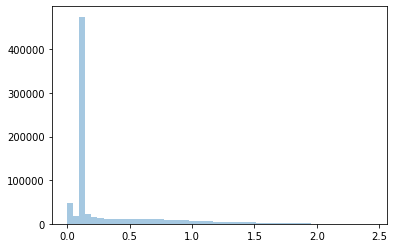

In [15]:
_ = sns.distplot(conv1_neuron_activations.flatten(), kde=False)

In [19]:
pd.Series(conv1_neuron_activations.flatten()).describe()

count    802816.000000
mean          0.325011
std           0.386439
min           0.000000
25%           0.139724
50%           0.139724
75%           0.333538
max           2.435588
dtype: float64

It is so striking that more than half of the patches lead to the same small activation (around 6% of the maximum activation). Is this a manifestation of a leaking fuzzy logic formula???

In [26]:
top_100_flat_idx = conv1_neuron_activations.flatten().argsort()[-100:]
reconstruct = np.zeros(conv1_neuron_activations.size)
reconstruct[top_100_flat_idx] = 1
reconstruct = reconstruct.reshape(conv1_neuron_activations.shape)
batch_idx, horiz_idx, vert_idx = reconstruct.nonzero()

In [42]:
pd.Series(conv1_neuron_activations.flatten()[top_100_flat_idx]).describe()

count    100.000000
mean       2.305081
std        0.038204
min        2.253812
25%        2.273070
50%        2.298209
75%        2.332448
max        2.435588
dtype: float64

In [38]:
def display_patch(k):
    b, h, v = batch_idx[k], horiz_idx[k], vert_idx[k]
    plt.imshow(saved_input[b, 0, h-2:h+2, v-2:v+2], cmap='gray')

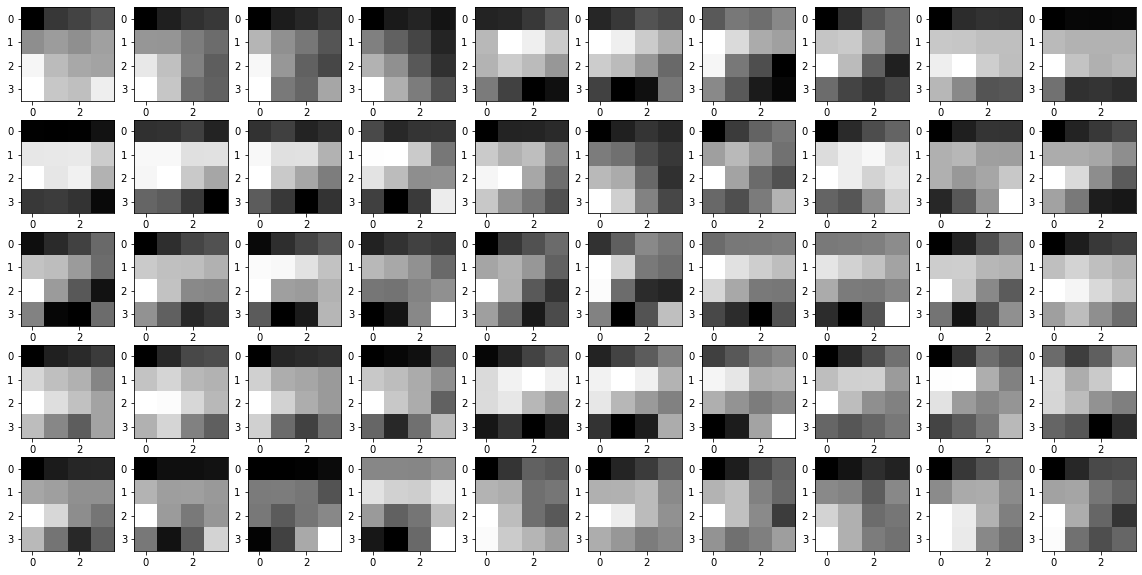

In [41]:
fig=plt.figure(figsize=(20, 10))
columns = 10
rows = 5
for i in range(1, columns*rows+1):
    fig.add_subplot(rows, columns, i)
    display_patch(i)

In [48]:
def display_patch_in_context(k):
    fig=plt.figure(figsize=(8, 4))

    fig.add_subplot(1, 2, 1)
    b, h, v = batch_idx[k], horiz_idx[k], vert_idx[k]
    plt.imshow(saved_input[b, 0], cmap='gray')
    
    fig.add_subplot(1, 2, 2)
    img_new = np.zeros_like(saved_input[b, 0])
    img_new[h-2:h+2, v-2:v+2] = saved_input[b, 0, h-2:h+2, v-2:v+2]
    plt.imshow(img_new, cmap='gray')

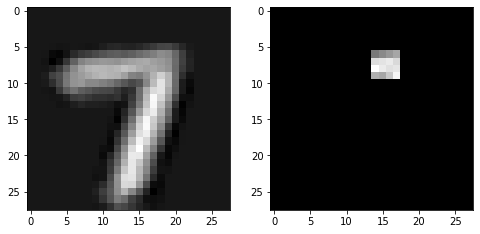

In [49]:
display_patch_in_context(0)

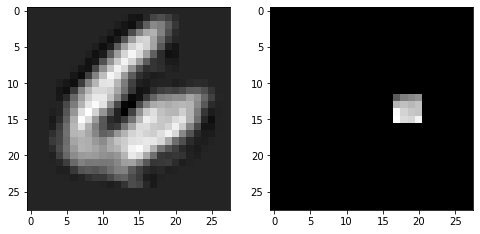

In [50]:
display_patch_in_context(1)

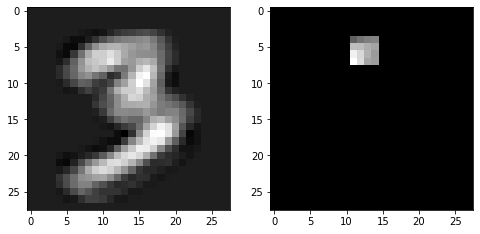

In [51]:
display_patch_in_context(2)

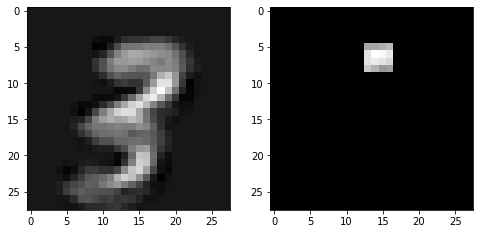

In [54]:
display_patch_in_context(5)

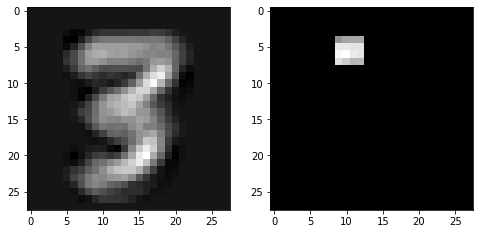

In [55]:
display_patch_in_context(9)

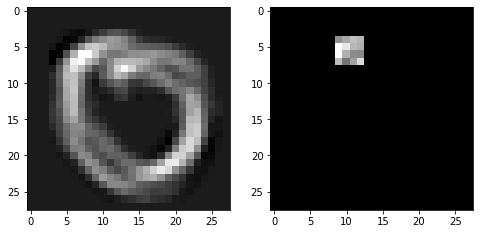

In [56]:
display_patch_in_context(26)

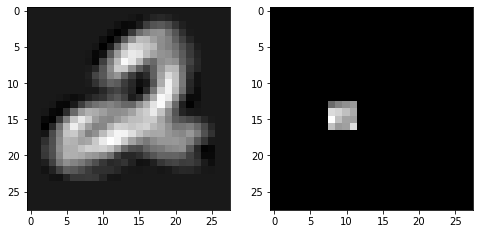

In [57]:
display_patch_in_context(80)

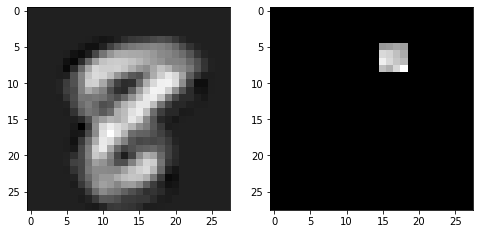

In [58]:
display_patch_in_context(90)

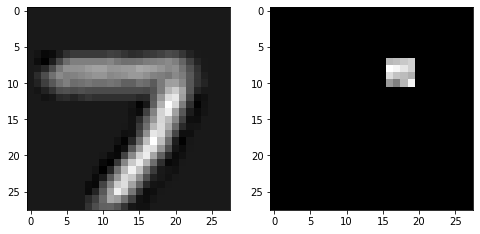

In [59]:
display_patch_in_context(60)

# Analyze activation patterns by clustering

# Analyze activation patterns using gradient boosted trees